In [1]:
%load_ext memory_profiler

In [2]:
base_grid_kwargs = {
    "size_x": 1080, 
    "size_y": 1080, 
    "center_lon": -20, 
    "center_lat": 65, 
    "rot": 0, 
    "topography_source": {
        "name": "SRTM15",
        "path": "/glade/derecho/scratch/noraloose/Datasets/SRTM15/SRTM15_V2.6.nc",
    }
}

In [3]:
grids = {
    "A": {"nx": 500, "ny": 500, "N": 100, **base_grid_kwargs},
    "B": {"nx": 2000, "ny": 2000, "N": 100, **base_grid_kwargs},  
    "C": {"nx": 2000, "ny": 2000, "N": 500, **base_grid_kwargs},   
}

In [4]:
from dask.diagnostics import Profiler
import multiprocessing

# Check the number of threads Dask will use
num_threads = multiprocessing.cpu_count()  # Default number of threads
print(f"Dask is likely using {num_threads} threads")

Dask is likely using 72 threads


# Performance

In [22]:
key = "B"

In [23]:
use_dask = True
bypass_validation = False
adjust_depth_for_sea_surface_height = False

In [24]:
from roms_tools import Grid, InitialConditions

We first create our grid object.

In [25]:
grid = Grid(**grids[key])

In [26]:
path = "/glade/derecho/scratch/noraloose/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120102.nc"

In [27]:
from datetime import datetime
ini_time = datetime(2012, 1, 2)

In [28]:
%%time
%%memit

initial_conditions = InitialConditions(
    grid=grid,
    ini_time=ini_time,
    source={"name": "GLORYS", "path": path},
    model_reference_date=datetime(
        2000, 1, 1
    ),  # model reference date. Default is January 1, 2000,
    use_dask=use_dask,  # default is False
    horizontal_chunk_size=50,
    bypass_validation=bypass_validation,
    adjust_depth_for_sea_surface_height=adjust_depth_for_sea_surface_height
)

INFO - Sea surface height will NOT be used to adjust depth coordinates.
INFO - Selected time entry closest to the specified start_time (2012-01-02 00:00:00) within the range [2012-01-02 00:00:00, 2012-01-03 00:00:00]: ['2012-01-02T12:00:00.000000000']


peak memory: 14333.95 MiB, increment: 6379.35 MiB
CPU times: user 7.98 s, sys: 2.83 s, total: 10.8 s
Wall time: 11.2 s


In [29]:
%%time
%%memit

initial_conditions_with_bgc = InitialConditions(
    grid=grid,
    ini_time=ini_time,
    source={"name": "GLORYS", "path": path},
    bgc_source={"name": "CESM_REGRIDDED", "path": "/glade/derecho/scratch/noraloose/Datasets/CESM_REGRIDDED/CESM-climatology_lowres_regridded.nc", "climatology": True},
    model_reference_date=datetime(
        2000, 1, 1
    ),  # model reference date. Default is January 1, 2000,
    use_dask=use_dask,  # default is False
    horizontal_chunk_size=50,
    bypass_validation=bypass_validation,
    adjust_depth_for_sea_surface_height=adjust_depth_for_sea_surface_height
)

INFO - Sea surface height will NOT be used to adjust depth coordinates.
INFO - Selected time entry closest to the specified start_time (2012-01-02 00:00:00) within the range [2012-01-02 00:00:00, 2012-01-03 00:00:00]: ['2012-01-02T12:00:00.000000000']


peak memory: 57668.99 MiB, increment: 48088.16 MiB
CPU times: user 18min 43s, sys: 10min 39s, total: 29min 22s
Wall time: 2min 30s


[########################################] | 100% Completed | 95.41 s
peak memory: 53568.99 MiB, increment: 16092.13 MiB
CPU times: user 15min 4s, sys: 7min 22s, total: 22min 26s
Wall time: 1min 44s


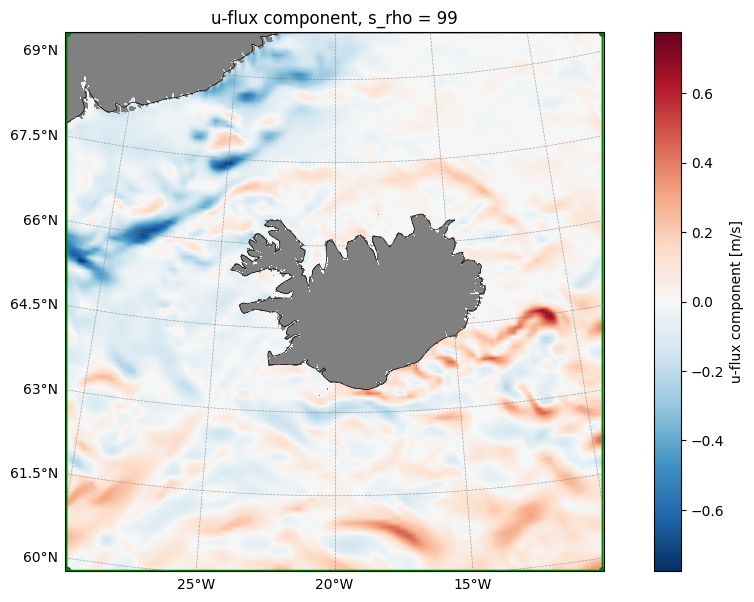

In [30]:
%%time
%%memit

initial_conditions.plot("u", s=-1)

In [ ]:
%%time
%%memit

initial_conditions.save("/glade/derecho/scratch/noraloose/forcing/my_initial_conditions.nc")

INFO - Writing the following NetCDF files:
/glade/derecho/scratch/noraloose/forcing/my_initial_conditions.nc


[############                            ] | 30% Completed | 160.49 s

In [ ]:
%%time
%%memit

initial_conditions_with_bgc.save("/glade/derecho/scratch/noraloose/forcing/my_initial_conditions.nc")

# Profiling

## 1 CPU (not sure, maybe 72 threads)

### Grid B
#### no BGC, not adjusted for SSH, chunk size 50
Initialization, `bypass_validation = False`:
```
peak memory: 14333.95 MiB, increment: 6379.35 MiB
CPU times: user 7.98 s, sys: 2.83 s, total: 10.8 s
Wall time: 11.2 s
```

### Grid A

#### no BGC, not adjusted for SSH, chunk size 50
Initialization, `bypass_validation = False`:

```
peak memory: 639.40 MiB, increment: 324.43 MiB
CPU times: user 1.83 s, sys: 533 ms, total: 2.36 s
Wall time: 2.53 s
```
Plot:
```
peak memory: 12134.36 MiB, increment: 7661.25 MiB
CPU times: user 1min 1s, sys: 35.1 s, total: 1min 36s
Wall time: 8.99 s
```
Save:
```
peak memory: 11370.80 MiB, increment: 6348.95 MiB
CPU times: user 3min 7s, sys: 1min 38s, total: 4min 45s
Wall time: 27.4 s
```

#### no BGC, not adjusted for SSH, chunk size 50
Initialization, `bypass_validation = False`:
```
peak memory: 13684.14 MiB, increment: 13130.31 MiB
CPU times: user 1min 18s, sys: 33.2 s, total: 1min 52s
Wall time: 12.6 s
```
Save:
```
peak memory: 26269.55 MiB, increment: 20630.03 MiB
CPU times: user 13min 6s, sys: 7min 33s, total: 20min 39s
Wall time: 1min 54s
```


#### no BGC, not adjusted for SSH, chunk size 20
Initialization, `bypass_validation = False`:
```
peak memory: 817.36 MiB, increment: 460.79 MiB
CPU times: user 2.48 s, sys: 516 ms, total: 3 s
Wall time: 3.16 s
```
Plot:
```
peak memory: 6389.26 MiB, increment: 1395.06 MiB
CPU times: user 1min 6s, sys: 13.9 s, total: 1min 20s
Wall time: 18.1 s
```
Save:
```
peak memory: 7889.25 MiB, increment: 1951.91 MiB
CPU times: user 3min 50s, sys: 43 s, total: 4min 33s
Wall time: 1min 18s
```


#### no BGC, adjusted for SSH, chunk size 20
Initialization, `bypass_validation = False`:
```
peak memory: 775.42 MiB, increment: 423.90 MiB
CPU times: user 2.82 s, sys: 611 ms, total: 3.43 s
Wall time: 13.9 s
```
Plot:
```
peak memory: 6730.00 MiB, increment: 1201.88 MiB
CPU times: user 1min 7s, sys: 13.6 s, total: 1min 20s
Wall time: 18.9 s
```
Save:
```
peak memory: 7554.26 MiB, increment: 1659.93 MiB
CPU times: user 3min 55s, sys: 44.4 s, total: 4min 39s
Wall time: 1min 21s
```

#### with BGC, not adjusted for SSH, chunk size 20
Initialization, `bypass_validation = False`:
```
peak memory: 7552.75 MiB, increment: 6952.27 MiB
CPU times: user 1min 11s, sys: 11.8 s, total: 1min 23s
Wall time: 24.2 s
```
Saving:
```
peak memory: 23519.73 MiB, increment: 17213.58 MiB
CPU times: user 16min 25s, sys: 3min 25s, total: 19min 51s
Wall time: 4min 55s
```

#### with BGC, adjusted for SSH, chunk size 20
Initialization, `bypass_validation = True`:
```
peak memory: 11558.01 MiB, increment: 321.03 MiB
CPU times: user 13.3 s, sys: 1.16 s, total: 14.5 s
Wall time: 14.7 s
```
Initialization, `bypass_validation = False`:
```
peak memory: 8359.45 MiB, increment: 7627.53 MiB
CPU times: user 1min 13s, sys: 10.2 s, total: 1min 23s
Wall time: 23.8 s
```
Save:
```
peak memory: 24709.82 MiB, increment: 18655.79 MiB
CPU times: user 16min 29s, sys: 3min 19s, total: 19min 48s
Wall time: 4min 55s
```

## 1 CPU (not sure, maybe 72 threads)

### Grid B

#### no BGC, not adjusted for SSH, chunk size 50
Initialization, `bypass_validation = False`:

```
peak memory: 14333.95 MiB, increment: 6379.35 MiB
CPU times: user 7.98 s, sys: 2.83 s, total: 10.8 s
Wall time: 11.2 s
```
Plot:
```
peak memory: 53568.99 MiB, increment: 16092.13 MiB
CPU times: user 15min 4s, sys: 7min 22s, total: 22min 26s
Wall time: 1min 44s
```

#### with BGC, not adjusted for SSH, chunk size 50
Initialization, `bypass_validation = False`:

```
peak memory: 57668.99 MiB, increment: 48088.16 MiB
CPU times: user 18min 43s, sys: 10min 39s, total: 29min 22s
Wall time: 2min 30s
```